# MTM Air Quality

## Load Libs


In [1]:
import os
from datetime import datetime as dt

import icecream
import numpy as np
import pandas as pd
import torch
from icecream import ic
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import BertModel, BertTokenizerFast

import hephaestus as hp
from hephaestus.analysis.plots import (
    evaluate_planetary_predictions,
    plot_training_history,
)
from hephaestus.models import TimeSeriesDecoder

# %%
torch.set_default_dtype(torch.float32)
# %%
icecream.install()
ic_disable = False  # Global variable to disable ic
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)
pd.options.mode.copy_on_write = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
model_name = "bert-base-uncased"
model = BertModel.from_pretrained(
    "bert-base-uncased", torch_dtype=torch.float32, attn_implementation="sdpa"
)
tokenizer = BertTokenizerFast.from_pretrained(model_name)

## Load and Process Data


In [3]:
# Load and preprocess the dataset (assuming you have a CSV file)
# Select numeric columns

csvs = [
    os.path.join("./data/air_quality/", f)
    for f in os.listdir("./data/air_quality/")
    if f.endswith(".csv")
]
dfs = [pd.read_csv(csv) for csv in csvs]
df = pd.concat(dfs, ignore_index=True)
del dfs
time_cols = ["year", "month", "day", "hour"]
df = df.sort_values(time_cols).reset_index(drop=True).drop("No", axis=1)
# Convert time columns to strings
for col in time_cols:
    df[col] = df[col].astype(str)
# replace . and lower case column names
df.columns = [c.replace(".", "_").lower() for c in df.columns]
# df = df.dropna()
df_no_na = df.dropna()
print(df.shape)
df.dropna(subset=["pm2_5"], inplace=True)
print(df.shape)
df = df.reset_index(drop=True)

df["idx"] = df.index // 32
# df = df.drop(["year", "month", "day", "hour"], axis=1)
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
numeric_cols.remove("idx")  # Remove idx column from scaling

# Create and fit scaler
scale_data = True
if scale_data:
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df.head()

(420768, 17)
(412029, 17)


,year,month,day,hour,pm2_5,pm10,so2,no2,co,o3,temp,pres,dewp,rain,wd,wspm,station,idx
0,2013,3,1,0,-0.913033,-0.944926,-0.501504,NaN,-0.371959,0.543684,-1.171139,0.986054,-1.525871,-0.078233,NW,2.147009,Gucheng,0
1,2013,3,1,0,-0.900660,-1.064852,-0.593995,-1.386030,-0.975055,0.596685,-1.381015,0.909631,-1.678018,-0.078233,WNW,1.102912,Huairou,0
2,2013,3,1,0,-0.913033,-1.075754,-0.547749,-1.215274,-0.802742,0.420016,-1.223608,1.310853,-1.728734,-0.078233,NNW,3.191105,Tiantan,0
3,2013,3,1,0,-0.950152,-1.075754,-0.131539,-1.243733,-0.802742,0.490683,-1.381015,0.957395,-1.605567,-0.078233,E,-0.985280,Changping,0
4,2013,3,1,0,-0.937779,-1.097559,-0.085294,-0.873762,-0.802742,0.208013,-1.241098,1.167559,-1.540361,-0.078233,NNW,2.147009,Guanyuan,0


In [4]:
df_categorical = df.select_dtypes(include=["object"]).astype(str)
unique_values_per_column = df_categorical.apply(
    pd.Series.unique
).values  # .flatten().tolist()
flattened_unique_values = np.concatenate(unique_values_per_column).tolist()
unique_values = list(set(flattened_unique_values))
unique_values

['2015',
 'WSW',
 'Wanshouxigong',
 'Aotizhongxin',
 '9',
 '19',
 '22',
 'N',
 'SSW',
 'Dingling',
 '2016',
 'SW',
 'Tiantan',
 'Shunyi',
 '5',
 '16',
 'ESE',
 '20',
 '23',
 '27',
 '26',
 '10',
 '30',
 '6',
 '25',
 '18',
 'nan',
 '11',
 '8',
 'NNW',
 '2014',
 'NNE',
 '2',
 'Wanliu',
 'Huairou',
 '1',
 'W',
 'Nongzhanguan',
 '14',
 '15',
 '28',
 '29',
 '3',
 'Changping',
 '2017',
 'ENE',
 '17',
 'Gucheng',
 '21',
 'WNW',
 '31',
 'E',
 '0',
 'NE',
 '2013',
 '24',
 'SE',
 'S',
 '4',
 'NW',
 'Dongsi',
 '12',
 '13',
 '7',
 'SSE',
 'Guanyuan']

## Initialize Model


In [5]:
# Get train test split at 80/20
time_series_config = hp.TimeSeriesConfig.generate(df=df)
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
# del df
train_ds = hp.TimeSeriesDS(train_df, time_series_config)
test_ds = hp.TimeSeriesDS(test_df, time_series_config)
len(train_ds), len(test_ds)

(10300, 2576)

In [6]:
N_HEADS = 8 * 4
tabular_decoder = TimeSeriesDecoder(time_series_config, d_model=512, n_heads=N_HEADS)

In [7]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

batch_size = 64

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
    collate_fn=hp.tabular_collate_fn,
    pin_memory=True if torch.cuda.is_available() else False,
)
tabular_decoder = tabular_decoder.to(device)  # Move model to device first

# Create a sample batch from the training dataset
example_batch = train_ds[0:6]
numeric_data = example_batch.numeric.to(device)
categorical_data = example_batch.categorical.to(device)

Using device: mps


In [8]:
with torch.no_grad():
    prediction = tabular_decoder(numeric_data, categorical_data)

    # Move predictions back to CPU for numpy operations if needed
    prediction = prediction.to("cpu")

    prediction.numeric = prediction.numeric.transpose(1, 2)
    prediction.categorical = prediction.categorical.permute(0, 2, 1, 3)


# Print prediction summary instead of all values
print("Prediction numeric shape:", prediction.numeric.shape)
print("Prediction categorical shape:", prediction.categorical.shape)
print(
    "Prediction contains NaN (numeric):",
    torch.isnan(prediction.numeric).any().item(),
)
print(
    "Prediction contains NaN (categorical):",
    torch.isnan(prediction.categorical).any().item(),
)

ic| /Users/kailukowiak/Hephaestus/hephaestus/models/models.py:538 in forward()
    numeric_inputs.shape: torch.Size([6, 11, 32])
    categorical_inputs.shape: torch.Size([6, 6, 32])
ic| /Users/kailukowiak/Hephaestus/hephaestus/models/models.py:327 in process_numeric()
    "col_token type": 'col_token type'
    numeric_col_embeddings.dtype: torch.float32
ic| /Users/kailukowiak/Hephaestus/hephaestus/models/models.py:335 in process_numeric()
    numeric_embedding.shape: torch.Size([512])
ic| /Users/kailukowiak/Hephaestus/hephaestus/models/models.py:339 in process_numeric()
    numeric_embedding.shape: torch.Size([6, 11, 32, 512])
ic| /Users/kailukowiak/Hephaestus/hephaestus/models/models.py:358 in process_numeric()
    numeric_embedding.shape: torch.Size([6, 11, 32, 512])
ic| /Users/kailukowiak/Hephaestus/hephaestus/models/models.py:404 in process_categorical()
    "Issue here": 'Issue here'
    categorical_inputs.shape: torch.Size([6, 6, 32])
    "args": 'args'
    categorical_inputs.sha

Prediction numeric shape: torch.Size([6, 32, 11])
Prediction categorical shape: torch.Size([6, 32, 6, 88])
Prediction contains NaN (numeric): False
Prediction contains NaN (categorical): False


In [9]:
ic.disable()

TensorBoard logs will be saved to: runs/2025-03-07T08-29-31_Heads_32_Batch_64_BetterAttention
To view logs, run: tensorboard --logdir=runs
Starting loop in hephaestus.training.training_loop.py
Using device: mps
TensorBoard log directory: runs/2025-03-07T08-29-31_Heads_32_Batch_64_BetterAttention
Epoch 1/2


Training:   0%|          | 0/161 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/2 completed in 431.60s
Train Loss: 1.6983, Val Loss: 1.4332
Train Numeric Loss: 0.4941, Val Numeric Loss: 0.2585
Train Cat Loss: 1.2042, Val Cat Loss: 1.1747
Current learning rate: 9.99e-04
--------------------------------------------------
Epoch 2/2


Training:   0%|          | 0/161 [00:00<?, ?it/s]

Validation:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 2/2 completed in 488.01s
Train Loss: 0.8301, Val Loss: 1.2722
Train Numeric Loss: 0.2278, Val Numeric Loss: 0.2059
Train Cat Loss: 0.6023, Val Cat Loss: 1.0663
Current learning rate: 9.96e-04
--------------------------------------------------
Training completed! TensorBoard logs saved to runs/2025-03-07T08-29-31_Heads_32_Batch_64_BetterAttention
To view training metrics, run:
tensorboard --logdir=runs


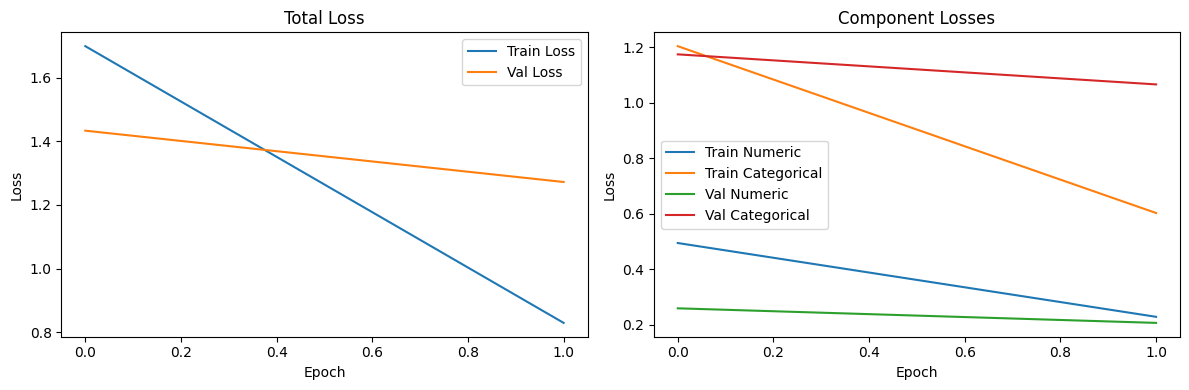

/var/folders/rs/qflxwtyx6kvfj8jcqx5zm5hr0000gn/T/ipykernel_19644/639977641.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_

Loaded best model from epoch 1 with validation loss 1.2722

=== Evaluating Model Predictions on Sample Data ===

Creating auto-regressive predictions...
Generating predictions for next 20 steps...
  Step 1 completed
  Step 6 completed
  Step 11 completed
  Step 16 completed

Processing results...

=== Comparison of Predicted vs Actual Values ===

Mean Absolute Error for Planet Positions:
Valid MAE calculations: 0/0 columns

No valid MAE values available for statistics.

Generating plots for planet positions...

Evaluation complete, but no valid MAE values were found.
Check for numerical stability issues in your model predictions.


/Users/kailukowiak/Hephaestus/hephaestus/analysis/plots.py:386: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(actuals.numeric), torch.tensor(actuals.categorical)


In [10]:
def init_weights(m):
    if hasattr(m, "weight") and m.weight is not None:
        if len(m.weight.shape) > 1:
            # Use Kaiming initialization for better stability
            torch.nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
            # Scale down initial weights to prevent explosions
            m.weight.data *= 0.05
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.zeros_(m.bias)


# Apply custom weight initialization
tabular_decoder.apply(init_weights)
# print("Applied conservative weight initialization")

# Move model to device
tabular_decoder.to(device)

# Set up training parameters with much more conservative values
learning_rate = 1e-3  # Reduced learning rate by 5x
num_epochs = 2
gradient_accumulation_steps = 4  # Increased for stability
max_grad_norm = 0.1  # Much tighter gradient clipping

# Add gradient explosion detection threshold
max_gradient_norm_allowed = 10.0
max_explosion_count = 5  # Allow this many explosions before reducing LR permanently

timestamp = dt.now().strftime("%Y-%m-%dT%H-%M-%S")
model_name = "BetterAttention"
log_dir = f"runs/{timestamp}_Heads_{N_HEADS}_Batch_{batch_size}_{model_name}"
save_dir = "images/planets"

# Ensure log directory exists
os.makedirs(log_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)
print(f"TensorBoard logs will be saved to: {log_dir}")
print("To view logs, run: tensorboard --logdir=runs")
writer = SummaryWriter(log_dir)
# Train the model with enhanced stability parameters
history = hp.train_model(
    model=tabular_decoder,
    train_dataset=train_ds,
    val_dataset=test_ds,
    batch_size=batch_size,  # Reduced batch size for stability
    epochs=num_epochs,
    learning_rate=learning_rate,
    log_dir=log_dir,
    save_dir=save_dir,
    device=device,
    gradient_accumulation_steps=gradient_accumulation_steps,
    max_grad_norm=max_grad_norm,
    explosion_threshold=max_gradient_norm_allowed,
    max_explosions_per_epoch=max_explosion_count,
    writer=writer,
)

# Import the plotting functions from our new module

# Visualize training history
plot_training_history(history, save_dir)

# Load best model for evaluation
best_model_path = os.path.join(save_dir, "best_model.pt")
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device)
    tabular_decoder.load_state_dict(checkpoint["model_state_dict"])
    print(
        f"Loaded best model from epoch {checkpoint['epoch']} with validation loss {checkpoint['val_loss']:.4f}"
    )

    # Evaluate the model on the test data using our new function
    try:
        results, pred_df, actual_df = evaluate_planetary_predictions(
            model=tabular_decoder,
            test_ds=test_ds,
            time_series_config=time_series_config,
            test_sample_idx=0,
            n_steps=20,
            save_dir=save_dir,
            device=device,
        )

        # Print summary of evaluation results with better NaN handling
        if results and "mae_results" in results:
            # Filter out NaN values before calculating average
            valid_maes = [v for v in results["mae_results"].values() if np.isfinite(v)]

            if valid_maes:
                avg_mae = sum(valid_maes) / len(valid_maes)
                print(
                    "\nEvaluation complete. Average MAE across all positions:",
                    f"{avg_mae:.6f}",
                )
                print(
                    f"Valid MAE values: {len(valid_maes)}/{len(results['mae_results'])}"
                )
            else:
                print("\nEvaluation complete, but no valid MAE values were found.")
                print("Check for numerical stability issues in your model predictions.")

    except Exception as e:
        print(f"Error during evaluation: {e}")

In [11]:
df_comp = hp.show_results_df(
    model=tabular_decoder,
    time_series_config=time_series_config,
    dataset=train_ds,
    idx=0,
)

TypeError: cannot unpack non-iterable TimeSeriesInputs object

In [ ]:
df_comp.output_df.loc[:, time_series_config.categorical_col_tokens].head()

,year,month,day,hour,wd,station
0,61,73,47,76,45,75
1,61,22,48,76,57,50
2,61,48,48,76,36,27
3,61,48,48,76,33,27
4,61,22,48,76,33,47
